Installation des packages Python nécessaires


In [1]:
!pip -q install alibi


In [2]:
from alibi.explainers import AnchorTabular
print("AnchorTabular OK")


AnchorTabular OK


Activation de R dans Colab

In [3]:
%load_ext rpy2.ipython


Installation de CASdatasets depuis le repo CNRS

In [4]:
%%R
# Dépendances parfois nécessaires
install.packages(c("zoo","xts"), repos="https://cloud.r-project.org")

# Installer CASdatasets depuis le dépôt CNRS (source)
install.packages("CASdatasets",
                 repos="http://dutangc.perso.math.cnrs.fr/RRepository/pub/",
                 type="source")

library(CASdatasets)
data("freMTPLfreq")
df <- freMTPLfreq

dim(df)
head(df)


  PolicyID ClaimNb Exposure Power CarAge DriverAge
1        1       0     0.09     g      0        46
2        2       0     0.84     g      0        46
3        3       0     0.52     f      2        38
4        4       0     0.45     f      2        38
5        5       0     0.15     g      0        41
6        6       0     0.75     g      0        41
                               Brand     Gas             Region Density
1 Japanese (except Nissan) or Korean  Diesel          Aquitaine      76
2 Japanese (except Nissan) or Korean  Diesel          Aquitaine      76
3 Japanese (except Nissan) or Korean Regular Nord-Pas-de-Calais    3003
4 Japanese (except Nissan) or Korean Regular Nord-Pas-de-Calais    3003
5 Japanese (except Nissan) or Korean  Diesel   Pays-de-la-Loire      60
6 Japanese (except Nissan) or Korean  Diesel   Pays-de-la-Loire      60


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/zoo_1.8-15.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/xts_0.14.1.tar.gz'

The downloaded source packages are in
	‘/tmp/Rtmp8hTGX5/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://dutangc.perso.math.cnrs.fr/RRepository/pub/src/contrib/CASdatasets_1.2-0.tar.gz'
Content type 'application/x-gzip' length 247610423 bytes (236.1 MB)
downloaded 236.1 MB


The downloaded source packages are in
	‘/tmp/Rtmp8hTGX5/downloaded_packages’
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: survival


Récupératiion df en pandas

In [5]:
import numpy as np
np.random.seed(123)

import pandas as pd
from rpy2.robjects import r
from rpy2.robjects import pandas2ri

pandas2ri.activate()

df = pandas2ri.rpy2py(r["df"])
df = pd.DataFrame(df)

print(df.shape)
df.head()


(413169, 10)


,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
1,1,0,0.09,4,0,46,2,1,1,76
2,2,0,0.84,4,0,46,2,1,1,76
3,3,0,0.52,3,2,38,2,2,8,3003
4,4,0,0.45,3,2,38,2,2,8,3003
5,5,0,0.15,4,0,41,2,1,9,60


Split 50/50 stratifié

In [6]:
# --- Sécurité : copie de travail
df = df.copy()

# ClaimNb en numérique
df["ClaimNb"] = pd.to_numeric(df["ClaimNb"], errors="coerce")
df = df.dropna(subset=["ClaimNb"]).copy()

# Création de y EXACTEMENT comme en R
# y = 1 si ClaimNb > 0, sinon 0
df["y"] = (df["ClaimNb"] > 0).astype(int)

# Vérification
print("Colonnes :", df.columns.tolist())
print(df[["ClaimNb", "y"]].head())
print("Prévalence y=1 :", df["y"].mean())
from sklearn.model_selection import train_test_split

drop_cols = [c for c in ["ClaimNb", "y", "PolicyID"] if c in df.columns]
X = df.drop(columns=drop_cols)
y = df["y"].astype(float)

X_train, X_calib, y_train, y_calib = train_test_split(
    X, y, test_size=0.5, random_state=23, stratify=df["y"]
)

print(X_train.shape, X_calib.shape)
print(y_train.mean(), y_calib.mean())



Colonnes : ['PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Region', 'Density', 'y']
   ClaimNb  y
1        0  0
2        0  0
3        0  0
4        0  0
5        0  0
Prévalence y=1 : 0.0372486803220958
(206584, 8) (206585, 8)
0.03724877047593231 0.037248590168695694


Prétraitement + Random Forest “comme R”

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# 0) Sécurité : colonnes en str Python (corrige numpy.str_ / rpy2)
# ============================================================
X_train = X_train.copy()
X_train.columns = [str(c) for c in X_train.columns]

# Si tu as X_test et que tu l'utiliseras ensuite, garde-le cohérent :
# X_test = X_test.copy()
# X_test.columns = [str(c) for c in X_test.columns]

# ============================================================
# 1) Détecter colonnes catégorielles vs numériques
# ============================================================
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols = [str(c) for c in cat_cols]  # sécurité supplémentaire
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols)

# ============================================================
# 2) Prétraitement: imputation + one-hot
# ============================================================
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median"))
        ]), num_cols),

        ("cat", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ============================================================
# 3) Random Forest en classification
# ============================================================
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=23,
    n_jobs=-1,
    min_samples_leaf=1,
    max_features=2
)

# ============================================================
# 4) Pipeline complet
# ============================================================
model = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf)
])

# ============================================================
# 5) Fit
# ============================================================
model.fit(X_train, y_train)
print("RF classifier trained.")


Categorical cols: []
Numeric cols: ['Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Region', 'Density']
RF classifier trained.


Scores + Brier + ECE

In [8]:
# (imports déjà faits au début + seed fixée)


# ============================================================
# 0) Sécuriser X_calib pour qu'il ait EXACTEMENT le format attendu
# ============================================================
X_calib = X_calib.copy()
X_calib.columns = [str(c) for c in X_calib.columns]

# Assurer mêmes colonnes que X_train (mêmes noms + même ordre)
train_cols = list(model.named_steps["prep"].feature_names_in_)  # colonnes vues au fit

# Ajouter les colonnes manquantes (remplies par NaN -> imputées ensuite)
missing_cols = [c for c in train_cols if c not in X_calib.columns]
for c in missing_cols:
    X_calib[c] = np.nan

# Garder uniquement les colonnes du train et dans le même ordre
X_calib = X_calib[train_cols]

# ============================================================
# 1) Probabilités prédites (classe 1) -> indispensable en classification
# ============================================================
rf_pred_prob = model.predict_proba(X_calib)[:, 1]  # proba de y=1

# ============================================================
# 2) Brier score (MSE des probabilités)
# ============================================================
y_true = np.asarray(y_calib).astype(float)
brier_rf = np.mean((rf_pred_prob - y_true) ** 2)

# ============================================================
# 3) ECE (Expected Calibration Error)
# ============================================================
def calculate_ece(predictions, actuals, n_bins=10):
    predictions = np.asarray(predictions)
    actuals = np.asarray(actuals)

    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    n = len(predictions)

    for i in range(n_bins):
        left, right = bins[i], bins[i + 1]
        in_bin = (predictions >= left) & (predictions < right)
        cnt = int(in_bin.sum())
        if cnt == 0:
            continue
        bin_mean = predictions[in_bin].mean()
        bin_obs = actuals[in_bin].mean()
        ece += (cnt / n) * abs(bin_mean - bin_obs)

    return ece

ece_rf = calculate_ece(rf_pred_prob, y_true, n_bins=10)

# ============================================================
# 4) Résumé
# ============================================================
print("Brier RF:", brier_rf)
print("ECE RF:", ece_rf)

print("Summary:",
      "min", float(rf_pred_prob.min()),
      "q25", float(np.quantile(rf_pred_prob, 0.25)),
      "med", float(np.quantile(rf_pred_prob, 0.50)),
      "mean", float(rf_pred_prob.mean()),
      "q75", float(np.quantile(rf_pred_prob, 0.75)),
      "max", float(rf_pred_prob.max()))


Brier RF: 0.03751833042990053
ECE RF: 0.01605821623888419
Summary: min 0.0 q25 0.008 med 0.024 mean 0.04017373411701439 q75 0.052 max 0.798


Reliability diagram

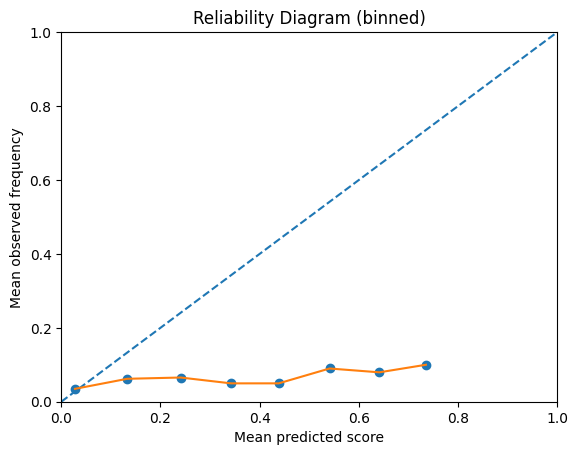

In [9]:
import matplotlib.pyplot as plt

def reliability_diagram(pred, y, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(pred, bins) - 1
    mean_pred, mean_obs = [], []

    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        mean_pred.append(pred[mask].mean())
        mean_obs.append(y[mask].mean())

    return np.array(mean_pred), np.array(mean_obs)

mp, mo = reliability_diagram(rf_pred_prob, y_calib.values, n_bins=10)

plt.figure()
plt.plot([0,1],[0,1], linestyle="--")
plt.scatter(mp, mo)
plt.plot(mp, mo)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Mean predicted score")
plt.ylabel("Mean observed frequency")
plt.title("Reliability Diagram (binned)")
plt.show()


Seuil 0.10 + sélection des 3 contrats

In [10]:
# Seuil identique à R
threshold = 0.10

rf_pred_class = (rf_pred_prob >= threshold).astype(int)
print("Nombre de contrats prédits à 1 :", rf_pred_class.sum(), "/", len(rf_pred_class))

# Construire le DF calibration pour filtrer
calib_df = X_calib.copy()
calib_df["y"] = y_calib.values.astype(int)
calib_df["rf_pred_prob"] = rf_pred_prob
calib_df["rf_pred_class"] = rf_pred_class

# Sélection : sinistrés réels (y=1) + score élevé
contracts_to_explain = (
    calib_df[calib_df["y"] == 1]
    .sort_values("rf_pred_prob", ascending=False)
    .head(3)
)

print("Top 3 contrats à expliquer :")
display(contracts_to_explain[["y", "rf_pred_prob", "rf_pred_class"]])

# Features à expliquer
X_explain = contracts_to_explain.drop(columns=["y", "rf_pred_prob", "rf_pred_class"])


Nombre de contrats prédits à 1 : 18155 / 206585
Top 3 contrats à expliquer :


,y,rf_pred_prob,rf_pred_class
100838,1,0.768,1
121449,1,0.686,1
169997,1,0.654,1


Encodage des données + noms de variables

In [11]:
import numpy as np
import pandas as pd

# Encodage via le préprocesseur
X_train_enc = model.named_steps["prep"].transform(X_train)
X_explain_enc = model.named_steps["prep"].transform(X_explain)

# Convertir sparse -> dense (obligatoire pour AnchorTabular)
X_train_enc = X_train_enc.toarray() if hasattr(X_train_enc, "toarray") else np.asarray(X_train_enc)
X_explain_enc = X_explain_enc.toarray() if hasattr(X_explain_enc, "toarray") else np.asarray(X_explain_enc)

feature_names = model.named_steps["prep"].get_feature_names_out()

print("Encoded train shape:", X_train_enc.shape)
print("Encoded explain shape:", X_explain_enc.shape)
print("Nb features:", len(feature_names))


Encoded train shape: (206584, 8)
Encoded explain shape: (3, 8)
Nb features: 8


Fonction de décision sur données encodées

In [12]:
from alibi.explainers import AnchorTabular

rf = model.named_steps["rf"]  # le RandomForestRegressor
threshold = 0.10              # ton seuil

def predict_fn_encoded(x: np.ndarray) -> np.ndarray:
    s = rf.predict(x)
    s = np.clip(s, 0.0, 1.0)
    return (s >= threshold).astype(int)


Anchors (fit + explications)

In [13]:
explainer = AnchorTabular(
    predict_fn_encoded,
    feature_names=feature_names.tolist()
)

explainer.fit(X_train_enc, disc_perc=(25, 50, 75))

for i in range(X_explain_enc.shape[0]):
    x = X_explain_enc[i]
    exp = explainer.explain(x, threshold=0.95)

    sc = np.clip(rf.predict(x.reshape(1, -1))[0], 0.0, 1.0)
    dec = int(sc >= threshold)

    print("\n==============================")
    print(f"Contrat #{i+1} | score={sc:.3f} | decision={dec}")
    print("Anchor :", " AND ".join(exp.anchor) if exp.anchor else "(aucune règle)")
    print("Precision :", exp.precision)
    print("Coverage  :", exp.coverage)



Contrat #1 | score=1.000 | decision=1
Anchor : 44.00 < DriverAge <= 54.00 AND 3.00 < Brand <= 6.00 AND Power <= 2.00 AND CarAge <= 3.00 AND 1.00 < Gas <= 2.00 AND 0.20 < Exposure <= 1.00 AND Region > 4.00 AND Density > 1410.00
Precision : 0.10975609756097561
Coverage  : 0.001



Contrat #2 | score=1.000 | decision=1
Anchor : Gas <= 1.00 AND Brand > 6.00 AND DriverAge <= 54.00 AND 3.00 < CarAge <= 7.00 AND Power <= 3.00 AND 67.00 < Density <= 289.00 AND Exposure > 0.54 AND Region > 6.00
Precision : 0.13892709766162312
Coverage  : 0.0002



Contrat #3 | score=1.000 | decision=1
Anchor : Gas <= 1.00 AND 0.54 < Exposure <= 1.00 AND 2.00 < Power <= 3.00 AND 7.00 < CarAge <= 12.00 AND 67.00 < Density <= 1410.00 AND 3.00 < Brand <= 6.00 AND Region <= 4.00 AND 44.00 < DriverAge <= 54.00
Precision : 0.0853932584269663
Coverage  : 0.0015
